In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Select and load testing data

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
########################################
########################################
# Select Energy (40 or 50 keV)
Energy = 50
# Select diff amount (H or L)
Diff = 'L'
########################################
########################################


In [4]:
# Read pandas dataframe with all information about sparse testing tensors
st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff,energy
0,"[0.5802274029150344, 0.3799563143728668, 0.720...","[0.30809212310356493, -1.5579568096290122, -2....",0.02,50
1,"[0.3098683381252501, -0.9042533466931167, -0.2...","[1.2954023192030866, 2.1819201599226625, 1.587...",0.02,50
2,"[0.4655218454829421, 0.8850151948351279, 0.006...","[-2.3092640489123255, -0.705399463976262, 1.36...",0.02,50
3,"[-0.16437865239140792, -0.189560339600941, 0.9...","[-0.4027173478408969, 0.22384229344563353, -1....",0.02,50
4,"[-0.31783467693146245, 0.8994928547912531, -0....","[-1.4972835316293673, -0.13970527671113256, -0...",0.02,50


In [5]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

# Create DataLoader
batch_size = 64
test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

# Print tensor shapes
for X_plot, y_plot, offset_plot in test_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break
    
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


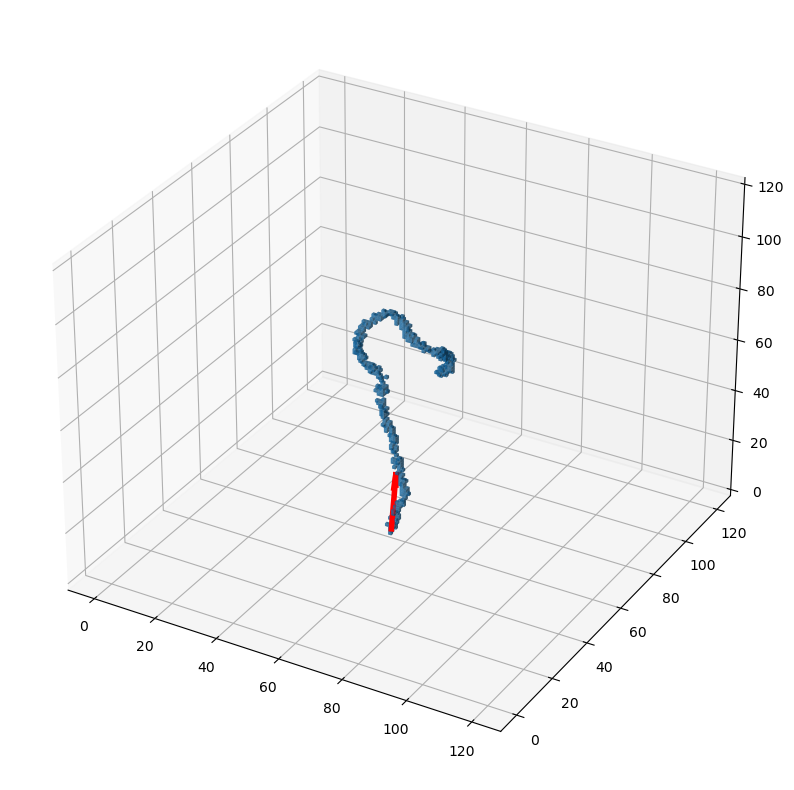

In [6]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Test HSCDC CNN Model

In [7]:
# Load the model
model_HSCDC = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC.pt').to(device)

# Obtain predictions and Labels
v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC = mytools.test_HSCDC(test_dataloader,model_HSCDC,device)

18.982185


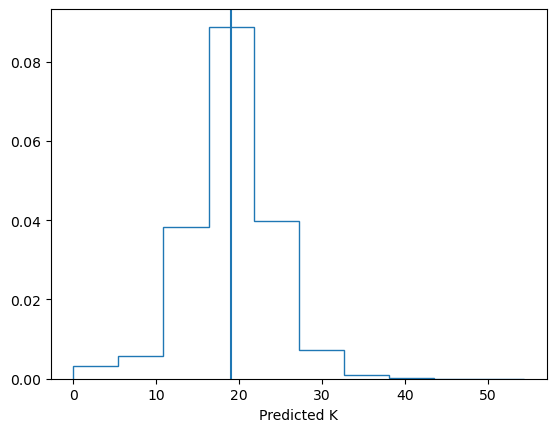

In [8]:
# Plot a histogram of the predicted kappa values
plt.hist(K_pred_HSCDC.flatten().numpy(), density=True, histtype='step')
plt.axvline(np.mean(K_pred_HSCDC.flatten().numpy()),label="Mean")
plt.xlabel("Predicted K")
print(np.mean(K_pred_HSCDC.flatten().numpy()))

In [9]:
# Compute the cosine similarity loss using the mean predictions from the HSCDC model
HSCDC_Loss = mytools.CSloss(v_pred_HSCDC, v_true_HSCDC)
HSCDC_Loss

tensor(-0.9368)

In [10]:
# Now compute the Loss versus efficiency cuts in K_pred (the uncertainty prediction in the HSCDC model)
CS = nn.CosineSimilarity()

# Percent of data that is cut
eff = np.arange(0,90,1)
# Coresponding percentiles
pers = np.percentile(K_pred_HSCDC,eff)

# Compute loss at each percentile
eff_loss = []
# Compute Head/Taill eff at each percentile
HT_eff = []
# Compute axial performance at each percentile
AP = []

for per in pers:
    
    T_vals = (K_pred_HSCDC >= per).flatten()
    v_pred_cut = v_pred_HSCDC[T_vals]
    v_true_cut = v_true_HSCDC[T_vals]
    
    eff_loss += [mytools.CSloss(v_pred_cut, v_true_cut)]
    
    vals = CS(v_pred_cut,v_true_cut)
    HT_eff += [torch.sum(vals>0).item() / len(vals)]
    AP += [torch.mean(-1.0*torch.abs(CS(v_pred_cut,v_true_cut)))]

    

Text(0, 0.5, 'Cosine Similairity Loss')

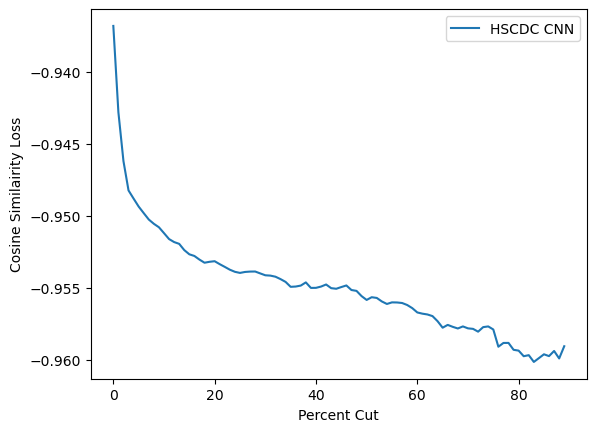

In [11]:
# Visualize how the predictions can be improved by cutting on Kappa
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Head Tail Efficiency')

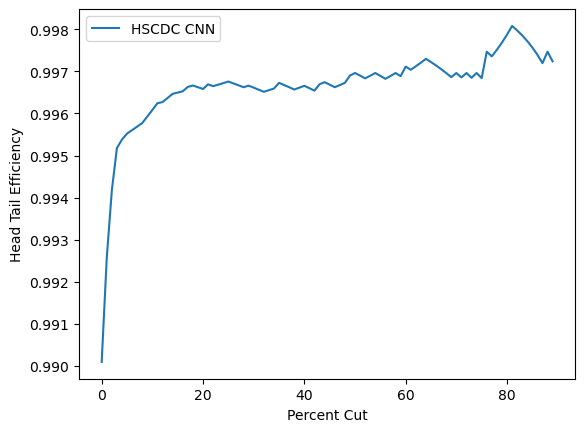

In [12]:
# Visualize how the Head/Tail efficiency can be improved by cutting on Kappa
plt.plot(eff,HT_eff, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Head Tail Efficiency")

Text(0, 0.5, 'Axial Performance')

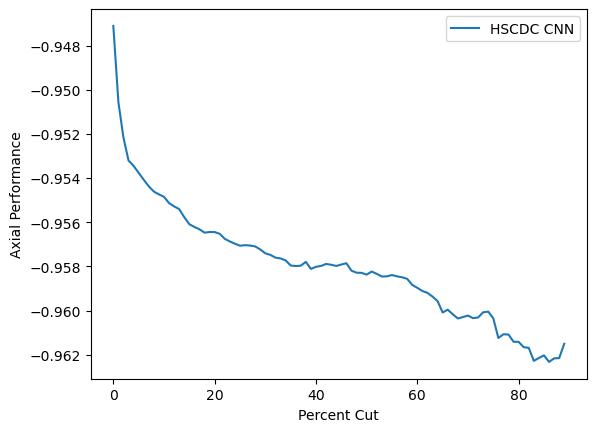

In [13]:
# Visualize how the axial performance can be improved by cutting on Kappa
plt.plot(eff,AP, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Axial Performance")

# Test Regular CNN Model

In [14]:
# Load the regular CNN model
model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN.pt').to(device)
# Obtain predictions and labels
v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN(test_dataloader,model_CNN,device)

In [15]:
# Compute the cosine similairity loss, we cannot make efficiency cuts here
CNN_Loss = mytools.CSloss(v_pred_CNN, v_true_CNN)
CNN_Loss

tensor(-0.9376)

In [16]:
# Compute the axial cosine similairity loss, we cannot make efficiency cuts here
CNN_AP_loss = torch.mean(-1.0*torch.abs(CS(v_pred_CNN,v_true_CNN)))
CNN_AP_loss

tensor(-0.9470)

In [17]:
# Compute the Head/Tail efficiency, we cannot make efficiency cuts here
vals = CS(v_pred_CNN,v_true_CNN)
CNN_HT_eff = torch.sum(vals>0).item() / len(vals)
CNN_HT_eff

0.9908245731299751

Text(0, 0.5, 'Cosine Similairity Loss')

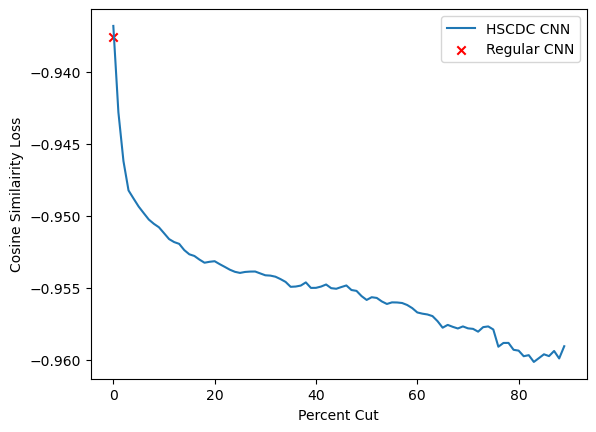

In [18]:
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.scatter([0],[CNN_Loss], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Axial Performance')

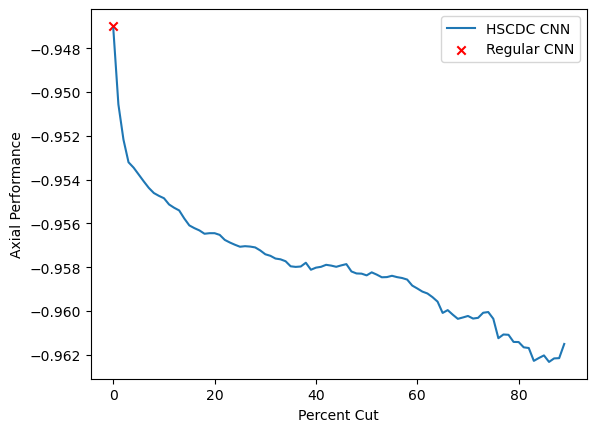

In [19]:
plt.plot(eff,AP, label = "HSCDC CNN")
plt.scatter([0],[CNN_AP_loss], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Axial Performance")

Text(0, 0.5, 'Head Tail Efficiency')

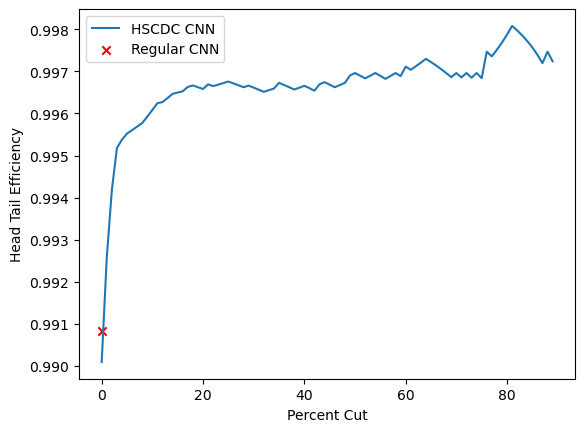

In [20]:
plt.plot(eff,HT_eff, label = "HSCDC CNN")
plt.scatter([0],[CNN_HT_eff], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Head Tail Efficiency")

# Test Non-ML algorithim

In [21]:
# Load the non-ML model
model_NML = mymodels.NML

# x/y/z length being kept in cm
eff_l= mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

In [22]:
# Copy sparse tensor info dataframe
NML_info = st_info.copy()
# Promote index to column
NML_info = NML_info.reset_index()

# Add position and charge information for each row
NML_info["positions"] = NML_info.apply(lambda row: torch.load('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/'+ 'sparse_recoils_' + str(row['index']) + '.pt').type(torch.FloatTensor).coalesce().indices().int().numpy()*vox_l-eff_l, axis=1)
NML_info["charges"] = NML_info.apply(lambda row: torch.load('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/'+ 'sparse_recoils_' + str(row['index']) + '.pt').type(torch.FloatTensor).coalesce().values().flatten().numpy()*1.0, axis=1)

NML_info.head()

,index,dir,offset,diff,energy,positions,charges
0,0,"[0.5802274029150344, 0.3799563143728668, 0.720...","[0.30809212310356493, -1.5579568096290122, -2....",0.02,50,"[[-1.0499999999999998, -1.0499999999999998, -1...","[2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 7.0, 3.0, 30.0,..."
1,1,"[0.3098683381252501, -0.9042533466931167, -0.2...","[1.2954023192030866, 2.1819201599226625, 1.587...",0.02,50,"[[-0.6999999999999997, -0.6999999999999997, -0...","[1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,2,"[0.4655218454829421, 0.8850151948351279, 0.006...","[-2.3092640489123255, -0.705399463976262, 1.36...",0.02,50,"[[-2.35, -2.3, -2.3, -2.3, -2.3, -2.3, -2.3, -...","[1.0, 1.0, 4.0, 1.0, 2.0, 3.0, 3.0, 1.0, 4.0, ..."
3,3,"[-0.16437865239140792, -0.189560339600941, 0.9...","[-0.4027173478408969, 0.22384229344563353, -1....",0.02,50,"[[-0.5999999999999996, -0.5999999999999996, -0...","[1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 9.0, ..."
4,4,"[-0.31783467693146245, 0.8994928547912531, -0....","[-1.4972835316293673, -0.13970527671113256, -0...",0.02,50,"[[-1.5999999999999999, -1.5999999999999999, -1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 3.0, ..."


## Test NML model with standard parameters and without cheating

In [23]:
# Get true and predicted directions
v_pred_NML, v_true_NML, off_true_NML = mytools.test_NML(NML_info, model_NML, cheat=False)

#Compute efficiency and Loss
# In this method, an efficency cut must be made as SVD can fail if it is not given >= 2 points
NML_eff = len(v_pred_NML)/len(NML_info)
NML_Loss = mytools.CSloss(torch.Tensor(v_pred_NML), torch.Tensor(v_true_NML))
    
print(NML_Loss, NML_eff)

tensor(-0.4515) 0.7465516193716959


## Test NML model with standard parameters and with cheating

In [24]:
# Get true and predicted directions
v_pred_NML_cheat, v_true_NML_cheat, off_true_NML_cheat = mytools.test_NML(NML_info, model_NML, cheat=True)

#Compute efficiency and Loss
# In this method, an efficency cut must be made as SVD can fail if it is not given >= 2 points
NML_eff_cheat = len(v_pred_NML_cheat)/len(NML_info)
NML_Loss_cheat = mytools.CSloss(torch.Tensor(v_pred_NML_cheat), torch.Tensor(v_true_NML_cheat))
    
print(NML_Loss_cheat, NML_eff_cheat)

tensor(-0.7147) 0.7465516193716959


## Test NML model with parameters tuned on the testing set

In [25]:
df_tuned_cheat = pd.read_pickle('../tune_NML_model_coarse/tune_NML_'+str(Energy)+'keV_'+Diff+'diff_cheat-'+str(True)+'.pk')
df_tuned = pd.read_pickle('../tune_NML_model_coarse/tune_NML_'+str(Energy)+'keV_'+Diff+'diff_cheat-'+str(False)+'.pk')

#Only consider cases with over 10% efficiency
df_tuned_cheat = df_tuned_cheat.loc[df_tuned_cheat.eff > 0.1].reset_index(drop = True)
df_tuned = df_tuned.loc[df_tuned.eff > 0.1].reset_index(drop = True)


min_tuned_cheat = df_tuned_cheat[['Loss']].idxmin()
min_tuned = df_tuned[['Loss']].idxmin()



In [26]:
Loss_tuned_cheat = df_tuned_cheat.iloc[min_tuned_cheat].Loss.item()
Eff_tuned_cheat = df_tuned_cheat.iloc[min_tuned_cheat].eff.item()
Loss_tuned = df_tuned.iloc[min_tuned].Loss.item()
Eff_tuned = df_tuned.iloc[min_tuned].eff.item()

In [27]:
print(Loss_tuned_cheat,Loss_tuned)

-0.8190730214118958 -0.6833602786064148


In [28]:
df_tuned_cheat.iloc[min_tuned_cheat]

,wo,n_sigma_L,n_sigma_H,Loss,eff
1526,inf,3.0,11.0,-0.819073,0.138847


In [29]:
df_tuned.iloc[min_tuned]

,wo,n_sigma_L,n_sigma_H,Loss,eff
1246,1.62,3.0,11.0,-0.68336,0.138847


# Test NML2 model with tuned epsilon

In [30]:
df_NML2 = pd.read_pickle('../tune_NML_model/tune_NML2_'+str(Energy)+'keV_'+Diff+'diff.pk')
NML2_tuned = df_NML2[['Loss']].idxmin()

In [31]:
NML2_loss = df_NML2.iloc[NML2_tuned].Loss.item()
NML2_eps = df_NML2.iloc[NML2_tuned].epsilon.item()

print("The Cossine Similairity Loss is: ", NML2_loss)
print("The tunes epsilon is: ", NML2_eps)

The Cossine Similairity Loss is:  -0.9430533051490784
The tunes epsilon is:  0.3


# Plot final results

Text(0, 0.5, 'Cosine Similairity Loss')

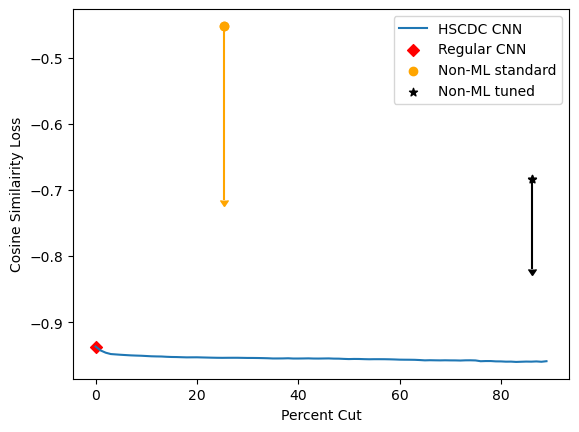

In [32]:
#Plot the performance of the NML methods alongside the convnets

plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.scatter([0],[CNN_Loss], marker="D", color = 'r', label = "Regular CNN")

# Double plot as a has to format the legend properly
plt.scatter([100*(1-NML_eff)], [NML_Loss], marker='o', color = 'orange', label = "Non-ML standard")
plt.errorbar([100*(1-NML_eff)], [NML_Loss], yerr=[ np.abs(NML_Loss-NML_Loss_cheat) ], uplims=[1], fmt='o', color = 'orange')

# Double plot as a has to format the legend properly
plt.scatter([100*(1-Eff_tuned)], [Loss_tuned], marker='*', color = 'k', label = "Non-ML tuned")
plt.errorbar([100*(1-Eff_tuned)], [Loss_tuned], yerr=[ np.abs(Loss_tuned-Loss_tuned_cheat) ], uplims=[1], fmt='*', color = 'k')




plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Cosine Similairity Loss')

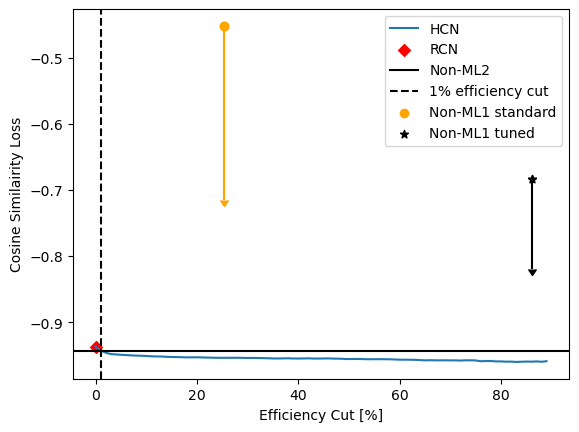

In [33]:
#Plot the performance of the NML2 methods alongside the convnets


plt.plot(eff,eff_loss, label = "HCN")
plt.scatter([0],[CNN_Loss], marker="D", color = 'r', label = "RCN")

plt.axhline(NML2_loss,color = 'k', label = "Non-ML2")
int_id = idx = (np.abs(np.array(eff_loss) - NML2_loss)).argmin()
plt.axvline(eff[int_id],color = 'k',ls='--', label=str(eff[int_id])+"% efficiency cut")

# Double plot as a has to format the legend properly
plt.scatter([100*(1-NML_eff)], [NML_Loss], marker='o', color = 'orange', label = "Non-ML1 standard")
plt.errorbar([100*(1-NML_eff)], [NML_Loss], yerr=[ np.abs(NML_Loss-NML_Loss_cheat) ], uplims=[1], fmt='o', color = 'orange')

# Double plot as a has to format the legend properly
plt.scatter([100*(1-Eff_tuned)], [Loss_tuned], marker='*', color = 'k', label = "Non-ML1 tuned")
plt.errorbar([100*(1-Eff_tuned)], [Loss_tuned], yerr=[ np.abs(Loss_tuned-Loss_tuned_cheat) ], uplims=[1], fmt='*', color = 'k')


plt.legend()
plt.xlabel("Efficiency Cut [%]")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Axial Cosine Similairity Loss')

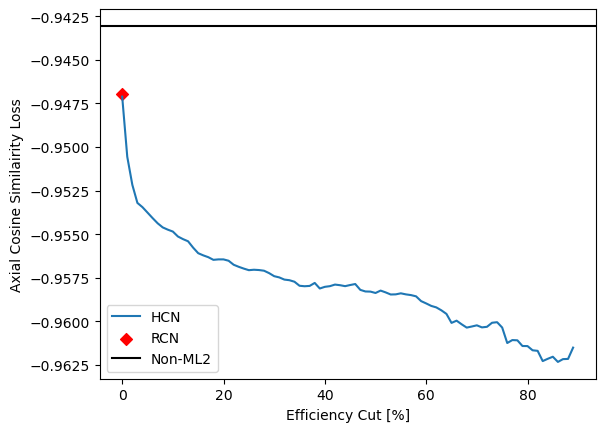

In [34]:
#Plot the axial performance of the NML2 methods alongside the convnets


plt.plot(eff,AP, label = "HCN")
plt.scatter([0],[CNN_AP_loss], marker="D", color = 'r', label = "RCN")

plt.axhline(NML2_loss,color = 'k', label = "Non-ML2")
int_id = idx = (np.abs(np.array(AP) - NML2_loss)).argmin()
#plt.axvline(eff[int_id],color = 'k',ls='--',label=str(eff[int_id])+" percent cut")

plt.legend()
plt.xlabel("Efficiency Cut [%]")
plt.ylabel("Axial Cosine Similairity Loss")